In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from helper_func import *

## Time Series visualisations

In [2]:
campania = data_by_region('Campania')
campania.tail(7)

,data,denominazione_regione,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido,codice_nuts_1,codice_nuts_2,incremento_deceduti,incremento_tamponi
8340,27-03-21,Campania,1594,168,1762,94339,96101,-150,2209,229146,...,NaN,NaN,318848.0,11588.0,3324429.0,205747.0,ITF,ITF3,31,24102
8361,28-03-21,Campania,1592,165,1757,94905,96662,561,2095,230662,...,NaN,NaN,320943.0,11588.0,3342774.0,209546.0,ITF,ITF3,18,22144
8382,29-03-21,Campania,1601,169,1770,93763,95533,-1129,1169,232906,...,NaN,NaN,322112.0,11588.0,3352781.0,210952.0,ITF,ITF3,54,11413
8403,30-03-21,Campania,1587,163,1750,92455,94205,-1328,1573,235743,...,NaN,NaN,323685.0,11588.0,3368070.0,216238.0,ITF,ITF3,64,20575
8424,31-03-21,Campania,1587,160,1747,91370,93117,-1088,2016,238809,...,NaN,NaN,325701.0,11588.0,3387252.0,220262.0,ITF,ITF3,38,23206
8445,01-04-21,Campania,1586,160,1746,91003,92749,-368,2258,241380,...,NaN,NaN,327959.0,11588.0,3406788.0,224461.0,ITF,ITF3,55,23735
8466,02-04-21,Campania,1558,155,1713,90057,91770,-979,2057,244359,...,NaN,NaN,330016.0,11588.0,3425301.0,228536.0,ITF,ITF3,57,22588


In [3]:
# on 12/06/20 there was a recalculation for the Campania Region
# -229 (registered value) = -230 (recalculation) + 1 (new infection on 12/06)
# https://www.salernotoday.it/cronaca/coronavirus-campania-ricalcolo-contagi-12-giugno-2020.html
campania.loc[campania['nuovi_positivi']<0, 'nuovi_positivi'] = 1

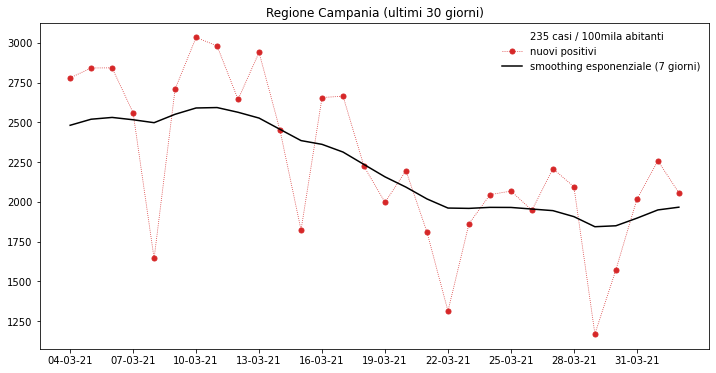

In [4]:
plot_smooth(campania, time_window=30, smooth_window=7, save=False)

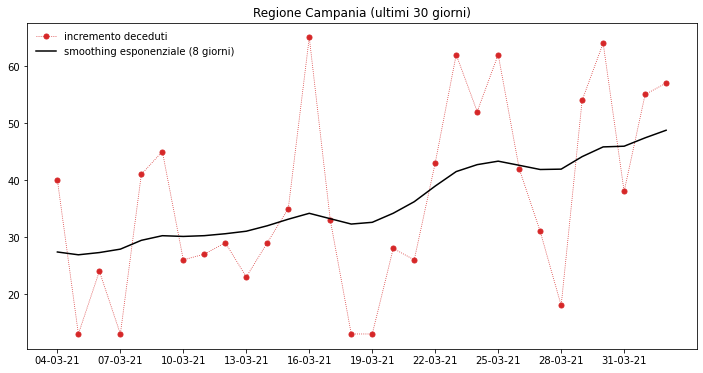

In [5]:
plot_smooth(campania, 'deceduti', 30, 8)

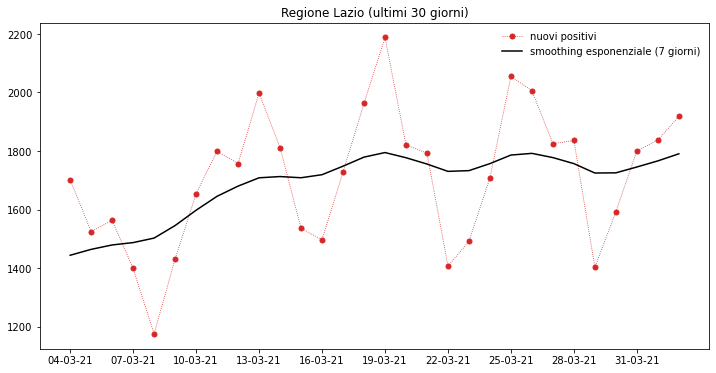

In [6]:
reg = data_by_region('lazio')
plot_smooth(reg, time_window=30)

## LSTM

In [7]:
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [8]:
train = campania.nuovi_positivi.values
sc = MinMaxScaler(feature_range = (0, 1))
train_sc = sc.fit_transform(train.reshape(-1, 1))

In [9]:
X, y = [], []
for i in range(1, len(campania)):
    X.append(train_sc[i-1:i, 0])
    y.append(train_sc[i, 0])

X, y = np.asarray(X), np.asarray(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape, y.shape

((403, 1, 1), (403,))

In [10]:
# Input
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))

# 1st hidden layer
x = keras.layers.LSTM(60, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x, training=True)

# 2nd hidden layer
x = keras.layers.LSTM(50)(x)
x = keras.layers.Dropout(0.2)(x, training=True)

# Output
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_lstm_model.hdf5',
                                                            save_best_only=True, monitor='val_loss',
                                                            mode='auto', verbose=1)


#model.summary()

In [11]:
history = model.fit(X, y, epochs = 100, batch_size = 21, validation_split = 0.15, shuffle=False,
                    callbacks=[early_stopping_monitor, model_checkpoint_callback])

Epoch 1/100
17/17 [==============================] - 8s 172ms/step - loss: 0.0240 - val_loss: 0.1721

Epoch 00001: val_loss improved from inf to 0.17209, saving model to best_lstm_model.hdf5
Epoch 2/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.1436

Epoch 00002: val_loss improved from 0.17209 to 0.14359, saving model to best_lstm_model.hdf5
Epoch 3/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0202 - val_loss: 0.1177

Epoch 00003: val_loss improved from 0.14359 to 0.11769, saving model to best_lstm_model.hdf5
Epoch 4/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0205 - val_loss: 0.0951

Epoch 00004: val_loss improved from 0.11769 to 0.09508, saving model to best_lstm_model.hdf5
Epoch 5/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0220 - val_loss: 0.0753

Epoch 00005: val_loss improved from 0.09508 to 0.07532, saving model to best_lstm_model.hdf5
Epoch 6/100
17/17 [==================

Epoch 49/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0088

Epoch 00049: val_loss did not improve from 0.00679
Epoch 50/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0087

Epoch 00050: val_loss did not improve from 0.00679
Epoch 51/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0014 - val_loss: 0.0084

Epoch 00051: val_loss did not improve from 0.00679
Epoch 52/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0085

Epoch 00052: val_loss did not improve from 0.00679
Epoch 53/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0099

Epoch 00053: val_loss did not improve from 0.00679
Epoch 54/100
17/17 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0100

Epoch 00054: val_loss did not improve from 0.00679
Epoch 55/100
17/17 [==============================] - 0s 7ms/step - loss: 0.0013 - val

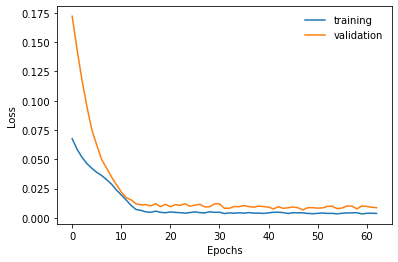

In [12]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)
plt.show()

In [13]:
predict = model.predict(X)
predict = sc.inverse_transform(predict)

test_predicted = []
for i in predict:
  test_predicted.append(i[0])

In [14]:
predicted_df = campania[1:][['data']]
predicted_df['predizioni'] = test_predicted
predicted_df['dati DPC'] = campania.nuovi_positivi
predicted_df[-30:].describe()

,predizioni,dati DPC
count,30.000000,30.000000
mean,2170.565324,2246.933333
std,556.519690,498.185738
min,1110.807129,1169.000000
25%,1760.892822,1959.500000
50%,2065.163818,2202.500000
75%,2640.427490,2662.750000
max,3103.569336,3034.000000


In [15]:
residuals = predicted_df['predizioni'] - predicted_df['dati DPC']
residuals.median()

10.525007247924805

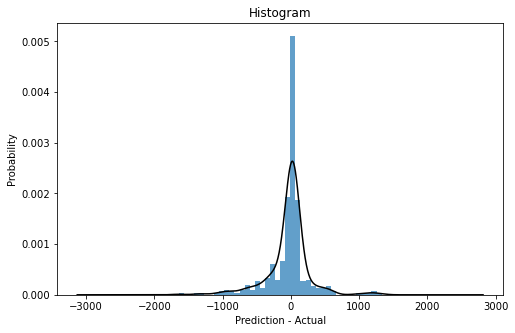

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
residuals.plot.hist(ax=ax, density=True, bins=40, color='tab:blue', alpha=0.7)
residuals.plot.kde(ax=ax, legend=False, title='Histogram', c='k')
ax.set_ylabel('Probability')
ax.set_xlabel('Prediction - Actual');

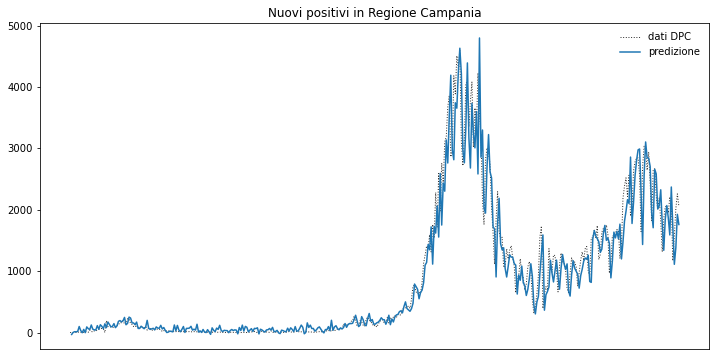

In [17]:
plt.figure(figsize=(12,6))
plt.plot(campania.data, campania.nuovi_positivi, 'k', ls=':', lw=1, alpha=0.8, label='dati DPC')
plt.plot(predicted_df.data, predicted_df.predizioni, 'tab:blue', label='predizione')
plt.xticks([])

plt.legend(frameon=False)
plt.title('Nuovi positivi in Regione Campania')
#plt.savefig('LSTM_fit.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

## Prediction for tomorrow
### Confidence interval estimated from $N\gg1$ predicts (*if* training=True in best_lstm_model)

In [18]:
# Confidence Level and number of iterations (better not to go below 1000)
cl = 0.9
N = 2000

In [19]:
last = campania.nuovi_positivi.values[-1]
last_sc = sc.transform(last.reshape(-1, 1))

X_tomorrow = []
X_tomorrow.append(last_sc)
X_tomorrow = np.array(X_tomorrow)
X_tomorrow = np.reshape(X_tomorrow, (X_tomorrow.shape[0], X_tomorrow.shape[1], 1))

Computing: [##################################################] 100%


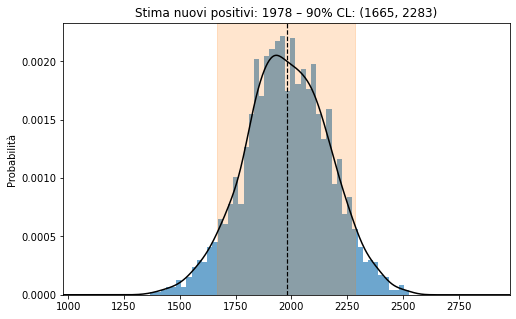

In [20]:
model = load_model('best_lstm_model.hdf5')

predict = []
for i in progressbar(range(0, N), "Computing: "):
    tomorrow = model.predict(X_tomorrow)
    predict.append(sc.inverse_transform(tomorrow))
    
predict = np.array(predict)
predict_df = pd.DataFrame(data={'predizioni': predict.flatten()})

fig, ax = plt.subplots(figsize=(8,5))
predict_df.plot.hist(ax=ax, density=True, bins=50, color='tab:blue', alpha=0.65, legend=False)
predict_df.plot.kde(ax=ax, legend=False, c='k')
ax.axvspan(predict_df.quantile(0.5 - cl/2)[0], predict_df.quantile(0.5 + cl/2)[0],
           color='tab:orange', alpha=0.2)
ax.axvline(predict_df.median()[0], c='k', ls='--', lw=1.2)

ax.set_xlim(predict_df.median()[0] - 1000, predict_df.median()[0] + 1000)
ax.set_ylabel('Probabilità')
plt.title(f'Stima nuovi positivi: {int(round(predict_df.median()[0],0))} – {int(round(100*cl,0))}% CL: ({int(round(predict_df.quantile(0.5 - cl/2)[0],0))}, {int(round(predict_df.quantile(0.5 + cl/2)[0],0))})')

fig.savefig(f'predizione_lstm_{N}_predict.png', dpi=300, bbox_inches='tight', facecolor='white');

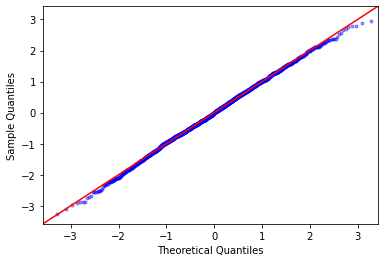

In [21]:
# Q-Q plot
z = (predict - predict.mean()) / predict.std()      # standardised values
fig = sm.qqplot(z.flatten(), line='45', marker='.', alpha=0.4)
plt.show()

In [28]:
from statsmodels.stats.stattools import robust_kurtosis, robust_skewness

print(f'Excess kurtosis:{round(robust_kurtosis(predizioni_predict)[0],4)}')
print(f'Excess skewness:{round(np.float64(robust_skewness(predizioni_predict)[0][0][0]),4)}')

Excess kurtosis:-0.2276
Excess skewness:-0.0105


In [24]:
cl = [0.68, 0.9, 0.95, 0.997]

def mad(arr):
    """Median Absolute Deviation: a robust version of standard deviation"""
    arr = np.ma.array(arr).compressed()
    med = np.median(arr)
    return np.median(np.abs(arr - med))

print(f'An estimate for tomorrow is: {int(round(predict.mean(),0))} ± {int(round(predict.std(),0))} (STD)')
print(f'A robust one is: {int(round(np.median(predict),0))} ± {int(round(mad(predict),0))} (MAD)\n')

for i in cl:
    lower_lim = np.quantile(predict, 0.5 - i/2)
    upper_lim = np.quantile(predict, 0.5 + i/2)
    print(f'{100*i}% CL: ({int(round(lower_lim,0))}, {int(round(upper_lim,0))})')

An estimate for tomorrow is: 1979 ± 187 (STD)
A robust one is: 1978 ± 127 (MAD)

68.0% CL: (1800, 2167)
90.0% CL: (1665, 2283)
95.0% CL: (1595, 2345)
99.7% CL: (1434, 2498)


## GRU (Under construction)

In [10]:
ripetizioni_gru = 100

train = campania.nuovi_positivi.values
sc = MinMaxScaler(feature_range = (0, 1))
train_sc = sc.fit_transform(train.reshape(-1, 1))

In [ ]:
X, y = [], []
    
for i in range(1, len(campania)):
    X.append(train_sc[i-1:i, 0])
    y.append(train_sc[i, 0])

X, y = np.asarray(X), np.asarray(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))
x = keras.layers.GRU(60, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x, training=True)
x = keras.layers.GRU(50)(x)
x = keras.layers.Dropout(0.2)(x, training=True)
outputs = keras.layers.Dense(1, activation='linear')(x)

model_gru = keras.Model(inputs=inputs, outputs=outputs)
model_gru.compile(optimizer='adam', loss='mse')
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss')

ieri = campania.nuovi_positivi.values[-1]
ieri_sc = sc.transform(ieri.reshape(-1, 1))
X_domani = []
X_domani.append(ieri_sc)
X_domani = np.array(X_domani)
X_domani = np.reshape(X_domani, (X_domani.shape[0], X_domani.shape[1], 1))

predizioni_gru = []

for j in range(0, ripetizioni_gru):
    
    print(f'loop #{j+1}')
    model_gru.fit(X, y, epochs = 100, batch_size = 21, validation_split = 0.15,  shuffle=False,
                  callbacks=[early_stopping_monitor])
    
    domani = model_gru.predict(X_domani)
    predizioni_gru.append(sc.inverse_transform(domani))
    
predizioni_gru = np.array(predizioni_gru)

In [ ]:
predizioni_gru_df = pd.DataFrame(data={'predizioni': predizioni_gru.flatten()})

cl = 0.9

fig, ax = plt.subplots(figsize=(8,5))
predizioni_gru_df.plot.hist(ax=ax, density=True, bins=50, legend=False, color='tab:blue', alpha=0.65)
predizioni_gru_df.plot.kde(ax=ax, c='k', legend=False)
ax.axvspan(predizioni_gru_df.quantile(0.5 - cl/2)[0], predizioni_gru_df.quantile(0.5 + cl/2)[0],
           color='tab:orange', alpha=0.2)
ax.axvline(predizioni_gru_df.median()[0], c='k', ls='--', lw=1.2, label='mediana')
ax.set_xlim(predizioni_gru_df.median()[0] - 1000, predizioni_gru_df.median()[0] + 1000)
ax.set_ylabel('Probabilità')
plt.title(f'Stima nuovi positivi: {int(round(predizioni_gru_df.median()[0],0))} – {int(round(100*cl,0))}% CL: ({int(round(predizioni_gru_df.quantile(0.5 - cl/2)[0],0))}, {int(round(predizioni_gru_df.quantile(0.5 + cl/2)[0],0))})')

fig.savefig('predizione_gru.png', dpi=300, bbox_inches='tight', facecolor='white');

## Multivariate forecasting (Under construction)
### Model using ```nuovi_positivi``` + ```incremento_tamponi```

In [56]:
#campania.isna().sum()

In [74]:
train_2 = campania.iloc[:,[8,-1]].values
sc_2 = MinMaxScaler(feature_range = (0, 1))
train_2_sc = sc_2.fit_transform(train_2)

In [75]:
#train_2_sc

In [ ]:
X, y = [], []

for i in range(1, len(campania)):
    X.append(train_2_sc[i-1:i])
    y.append(train_2_sc[i,0])

X, y = np.asarray(X), np.asarray(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 2))
X.shape, y.shape

In [77]:
inputs = keras.layers.Input(shape=(X.shape[1], X.shape[2]))

# 1° hidden layer
x = keras.layers.LSTM(100, return_sequences=True)(inputs)
x = keras.layers.Dropout(0.2)(x)#, training=True)  #(prova L2)

# 2° hidden layer
x = keras.layers.LSTM(80)(x)
x = keras.layers.Dropout(0.2)(x)#, training=True)

# uscita
outputs = keras.layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

# callbacks
early_stopping_monitor = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='best_lstm_model_2_feat.hdf5',
                                                            save_best_only=True, monitor='val_loss',
                                                            mode='auto', verbose=1)


#model.summary()

In [ ]:
history = model.fit(X, y, epochs = 100, batch_size = 21, validation_split = 0.15, shuffle=False,
                    callbacks=[early_stopping_monitor, model_checkpoint_callback])

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('# of epochs')
plt.ylabel('Loss')
plt.legend(frameon=False)

plt.show()

In [ ]:
predict = model.predict(X)
predict = sc_2.inverse_transform(predict + [0,0])

test_predicted = []
for i in predict:
  test_predicted.append(i[0])

predicted_df = campania[1:][['data']]
predicted_df['predizioni'] = test_predicted
predicted_df['dati DPC'] = campania.nuovi_positivi
predicted_df

In [ ]:
errors = predicted_df['predizioni'] - predicted_df['dati DPC']
errors.median()

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
errors.plot.hist(ax=ax, density=True, bins=40, color='tab:blue', alpha=0.7)
errors.plot.kde(ax=ax, legend=False, title='Histogram', c='k')
ax.set_ylabel('Probability')
ax.set_xlabel('Prediction - Actual');

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(campania.data, campania.nuovi_positivi, 'k', ls=':', lw=1, alpha=0.8, label='dati DPC')
plt.plot(predicted_df.data, predicted_df.predizioni, 'tab:blue', label='predizione')
plt.xticks([])

plt.legend(frameon=False)
plt.title('Nuovi positivi in Regione Campania');
#plt.savefig('LSTM_fit.png', dpi=300, bbox_inches='tight', facecolor='white');

In [68]:
ieri = campania.iloc[:,[8,-1]].values[-1]
ieri_sc = sc_2.transform(ieri.reshape(1,-1))

In [69]:
X_domani = []
X_domani.append(ieri_sc)
X_domani = np.array(X_domani)
X_domani = np.reshape(X_domani, (X_domani.shape[0], X_domani.shape[1], 2))

In [ ]:
# scaler remembers that I passed it a 2D input with two columns, and works under the assumption that
# all subsequent data passed to it will have the same number of features/columns. So I need to pass
# inverse_transform an input with the same number of columns (I add zeroes)

domani = model.predict(X_domani)
domani = sc_2.inverse_transform(domani+[0,0])
int(domani[0][0])